In [481]:
%matplotlib inline

import pandas as pd
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt

### Set up Docker image
```bash
docker pull postgres
```

```bash
docker run
    --name TrueNorthDB
    -p 5455:5432
    -e POSTGRES_USER=tn_user
    -e POSTGRES_PASSWORD=***********
    -e POSTGRES_DB=tn_db
    -d
    postgres
```

```bash
docker exec TrueNorthDB env
```

### Load table

In [482]:
df = pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")
print(len(df['Name']))
print(df.head(0))

16719
Empty DataFrame
Columns: [Name, Platform, Year_of_Release, Genre, Publisher, NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales, Critic_Score, Critic_Count, User_Score, User_Count, Developer, Rating]
Index: []


### Convert data types

In [483]:
df.replace('tbd', None, inplace=True)

data_types = {
    'Name': str,
    'Platform': str,
    'Year_of_Release': int,
    'Genre': str,
    'Publisher': str,
    'NA_Sales': float,
    'EU_Sales': float, 
    'JP_Sales': float, 
    'Other_Sales': float, 
    'Global_Sales': float, 
    'Critic_Score': float, 
    'Critic_Count': int, 
    'User_Score': float, 
    'User_Count': int, 
    'Developer': str, 
    'Rating': str,
}

df = df.fillna(-1).astype(data_types)
df.replace(-1, None, inplace=True)
df.replace('-1', None, inplace=True)
print(len(df['Name']))
df = df.dropna(subset=['Name'])
print(len(df['Name']))

# UNEXPECTED BEHAVIOUR

# df = df.groupby([
#     'Name', 'Platform','Year_of_Release','Genre',
#     'Publisher','Developer','Rating',
#     'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count',
#     ]).agg({
#         'NA_Sales': 'sum', 
#         'EU_Sales': 'sum',
#         'JP_Sales': 'sum',
#         'Other_Sales': 'sum',
#         'Global_Sales': 'sum',
#     }).reset_index()

print(len(df['Name']))

16719
16717
16717


### Set up connection to ElephantSQL / Docker image
Load credentials locally

In [484]:
import pickle 
with open('./pass.pkl', 'rb') as handle:
    passdict = pickle.load(handle)

# ELEPHANTSQL (ommitted because of free-tier limits)
# dbname = "qjiqyhgb"
# user = "qjiqyhgb"
# password = passdict['password']
# host = "tyke.db.elephantsql.com"
# port = "5432"

# DOCKER IMAGE
dbname = "tn_db"
user = "tn_user"
password = passdict['password']
host = "localhost"
port = "5455"

print(password)

tn_postgres


### Set up SQLAlchemy engine

In [485]:
# ELEPHANTSQL (no port required)
# engine = sqlalchemy.create_engine(
#     f"postgresql+psycopg2://{user}:{password}@{host}/{dbname}"
# )

engine = sqlalchemy.create_engine(
    f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}"
)
print(f"Engine setup successful = {bool(engine)}")


Engine setup successful = True


### Fill main table with entries from the dataframe

In [486]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text(
        """
        DROP TABLE IF EXISTS video_game_sales 
        """
    )
    result = conn.execute(query)
    conn.commit()

    df.to_sql(name="video_game_sales", con=engine, if_exists="replace")

    query = sqlalchemy.text(
        """
        SELECT COUNT(*) FROM video_game_sales
        """
    )
    result = conn.execute(query)
    rows = result.fetchall()
    temp = pd.DataFrame(rows)
    print(temp)

Connection successful = True


   count
0  16717


Check for data types

In [487]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")
    query = sqlalchemy.text(
        """
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_schema = 'public'
            AND table_name = 'video_game_sales';
        """
    )
    result = conn.execute(query)
    rows = result.fetchall()
    print(pd.DataFrame(rows))


Connection successful = True
        column_name         data_type
0             index            bigint
1              Name              text
2          Platform              text
3   Year_of_Release            bigint
4             Genre              text
5         Publisher              text
6          NA_Sales  double precision
7          EU_Sales  double precision
8          JP_Sales  double precision
9       Other_Sales  double precision
10     Global_Sales  double precision
11     Critic_Score  double precision
12     Critic_Count            bigint
13       User_Score  double precision
14       User_Count            bigint
15        Developer              text
16           Rating              text


### Sum duplicate entries by sales

In [488]:
# with engine.connect() as conn:
#     print(f"Connection successful = {bool(conn)}")
#     query = sqlalchemy.text(
#         """
#             CREATE TEMP TABLE tmp(
            
#             )
#         """
#     )
#     result = conn.execute(query)
#     rows = result.fetchall()
#     print(pd.DataFrame(rows))

# Dimensional model

### Game critics table

In [489]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text("DROP TABLE IF EXISTS game_critics")

    conn.execute(query)
    conn.commit()

    meta = sqlalchemy.MetaData()

    students = sqlalchemy.Table(
        'game_critics', 
        meta,
        sqlalchemy.Column('index', sqlalchemy.Integer), 
        sqlalchemy.Column('Name', sqlalchemy.Text),
        sqlalchemy.Column('Platform', sqlalchemy.Text),
        sqlalchemy.Column('Year_of_Release', sqlalchemy.Integer),
        sqlalchemy.Column('Critic_Score', sqlalchemy.Numeric(scale=3)), 
        sqlalchemy.Column('Critic_Count', sqlalchemy.Integer),
        sqlalchemy.Column('User_Score', sqlalchemy.Numeric(scale=3)), 
        sqlalchemy.Column('User_Count', sqlalchemy.Integer),
        sqlalchemy.PrimaryKeyConstraint("index") #('Name', 'Platform','Year_of_Release'),  
    )

    meta.create_all(engine)

    query = sqlalchemy.text(
        """
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_schema = 'public'
            AND table_name = 'game_critics';
        """
    )
    result = conn.execute(query)
    rows = result.fetchall()
    print(pd.DataFrame(rows))

Connection successful = True
       column_name data_type
0            index   integer
1             Name      text
2         Platform      text
3  Year_of_Release   integer
4     Critic_Score   numeric
5     Critic_Count   integer
6       User_Score   numeric
7       User_Count   integer


In [490]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text(
        f"""
        TRUNCATE TABLE game_critics;

        INSERT INTO game_critics (
            "index",
            "Name",
            "Platform",
            "Year_of_Release",
            "Critic_Score",
            "Critic_Count",
            "User_Score",
            "User_Count"
        )
        SELECT 
            video_game_sales."index",
            video_game_sales."Name",
            video_game_sales."Platform",
            video_game_sales."Year_of_Release",
            video_game_sales."Critic_Score",
            video_game_sales."Critic_Count",
            video_game_sales."User_Score",
            video_game_sales."User_Count"
        FROM video_game_sales
        ORDER BY video_game_sales."index";
        """
    )
    result = conn.execute(query)
    conn.commit()

    query = sqlalchemy.text(
        "SELECT * FROM game_critics LIMIT 3"
    )
    result = conn.execute(query)
    rows = result.fetchall()
    print(pd.DataFrame(rows))

Connection successful = True
   index               Name Platform  Year_of_Release Critic_Score  \
0      0         Wii Sports      Wii             2006           76   
1      1  Super Mario Bros.      NES             1985         None   
2      2     Mario Kart Wii      Wii             2008           82   

   Critic_Count User_Score  User_Count  
0          51.0          8       322.0  
1           NaN       None         NaN  
2          73.0        8.3       709.0  


### Average game critic score table
- the first table was separating critics depending on platform
- such data should be merged under one metric

In [491]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text("DROP TABLE IF EXISTS average_game_critic_score")

    conn.execute(query)
    conn.commit()

    meta = sqlalchemy.MetaData()

    students = sqlalchemy.Table(
        'average_game_critic_score', 
        meta,
        sqlalchemy.Column('Name', sqlalchemy.Text),
        sqlalchemy.Column('Year_of_Release', sqlalchemy.Integer),
        sqlalchemy.Column('Average_Critic_Score', sqlalchemy.Numeric(scale=3)),
        sqlalchemy.PrimaryKeyConstraint('Name', 'Year_of_Release'),  
    )

    meta.create_all(engine)
    
    query = sqlalchemy.text(
        """
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_schema = 'public'
            AND table_name = 'average_game_critic_score';
        """
    )
    result = conn.execute(query)
    rows = result.fetchall()
    print(pd.DataFrame(rows))

Connection successful = True
            column_name data_type
0                  Name      text
1       Year_of_Release   integer
2  Average_Critic_Score   numeric


In [492]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text(
        f"""
        TRUNCATE TABLE average_game_critic_score;

        INSERT INTO average_game_critic_score (
            "Name",
            "Year_of_Release",
            "Average_Critic_Score"
        )
        
        SELECT 
            T1."Name",
            T1."Year_of_Release",
            T1."Critic_Sum" / T2."Total_Critic" AS "Average_Critic_Score"
        FROM
        (
            SELECT 
                temp."Name",
                temp."Year_of_Release",
                SUM(temp."Critic_Sum") AS "Critic_Sum"
            FROM
                (
                SELECT 
                    game_critics."Name",
                    game_critics."Year_of_Release",
                    game_critics."Critic_Score" * game_critics."Critic_Count" AS "Critic_Sum"
                FROM game_critics
                WHERE game_critics."Critic_Score" IS NOT NULL
                ) AS temp
            GROUP BY
                "Name",
                "Year_of_Release"
        ) AS T1
        INNER JOIN
        (
            SELECT 
                game_critics."Name",
                game_critics."Year_of_Release",
                SUM(game_critics."Critic_Count") AS "Total_Critic"
            FROM game_critics
            WHERE game_critics."Critic_Score" IS NOT NULL
            GROUP BY 
                game_critics."Name",
                game_critics."Year_of_Release"
        ) AS T2
        ON T1."Name" = T2."Name" AND T1."Year_of_Release" = T2."Year_of_Release"        
        """
    )
    result = conn.execute(query)
    conn.commit()

    query = sqlalchemy.text(
        "SELECT * FROM average_game_critic_score LIMIT 3"
    )
    result = conn.execute(query)
    rows = result.fetchall()
    print(pd.DataFrame(rows))

Connection successful = True
              Name  Year_of_Release Average_Critic_Score
0  WipEout HD Fury             2009  89.0000000000000000
1    Lost Kingdoms             2002  72.0000000000000000
2      Ratatouille             2007  60.4461538461538462


### Average user score table

In [493]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text("DROP TABLE IF EXISTS average_game_user_score")

    conn.execute(query)
    conn.commit()

    meta = sqlalchemy.MetaData()

    students = sqlalchemy.Table(
        'average_game_user_score', 
        meta,
        sqlalchemy.Column('Name', sqlalchemy.Text),
        sqlalchemy.Column('Year_of_Release', sqlalchemy.Integer),
        sqlalchemy.Column('Average_User_Score', sqlalchemy.Numeric(scale=3)),
        sqlalchemy.PrimaryKeyConstraint('Name', 'Year_of_Release'),  
    )

    meta.create_all(engine)
    
    query = sqlalchemy.text(
        """
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_schema = 'public'
            AND table_name = 'average_game_user_score';
        """
    )
    result = conn.execute(query)
    rows = result.fetchall()
    print(pd.DataFrame(rows))

Connection successful = True
          column_name data_type
0                Name      text
1     Year_of_Release   integer
2  Average_User_Score   numeric


In [494]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text(
        f"""
        TRUNCATE TABLE average_game_user_score;

        INSERT INTO average_game_user_score (
            "Name",
            "Year_of_Release",
            "Average_User_Score"
        )
        
        SELECT 
            T1."Name",
            T1."Year_of_Release",
            T1."User_Sum" / T2."Total_User" AS "Average_User_Score"
        FROM
        (
            SELECT 
                temp."Name",
                temp."Year_of_Release",
                SUM(temp."User_Sum") AS "User_Sum"
            FROM
                (
                SELECT 
                    game_critics."Name",
                    game_critics."Year_of_Release",
                    game_critics."User_Score" * game_critics."User_Count" AS "User_Sum"
                FROM game_critics
                WHERE game_critics."User_Score" IS NOT NULL
                ) AS temp
            GROUP BY
                "Name",
                "Year_of_Release"
        ) AS T1
        INNER JOIN
        (
            SELECT 
                game_critics."Name",
                game_critics."Year_of_Release",
                SUM(game_critics."User_Count") AS "Total_User"
            FROM game_critics
            WHERE game_critics."User_Score" IS NOT NULL
            GROUP BY 
                game_critics."Name",
                game_critics."Year_of_Release"
        ) AS T2
        ON T1."Name" = T2."Name" AND T1."Year_of_Release" = T2."Year_of_Release"
        """
    )
    result = conn.execute(query)
    conn.commit()

    query = sqlalchemy.text(
        "SELECT * FROM average_game_user_score LIMIT 3"
    )
    result = conn.execute(query)
    rows = result.fetchall()
    print(pd.DataFrame(rows))

Connection successful = True
              Name  Year_of_Release  Average_User_Score
0  WipEout HD Fury             2009  8.4000000000000000
1    Lost Kingdoms             2002  8.0000000000000000
2      Ratatouille             2007  6.9520000000000000


### Sales table

In [495]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text("DROP TABLE IF EXISTS sales")

    conn.execute(query)
    conn.commit()

    meta = sqlalchemy.MetaData()

    students = sqlalchemy.Table(
        'sales', 
        meta,
        sqlalchemy.Column('index', sqlalchemy.Integer),  
        sqlalchemy.Column('Name', sqlalchemy.Text),
        sqlalchemy.Column('Platform', sqlalchemy.Text),
        sqlalchemy.Column('Year_of_Release', sqlalchemy.Integer),
        sqlalchemy.Column('NA_Sales', sqlalchemy.Numeric(scale=3)), 
        sqlalchemy.Column('EU_Sales', sqlalchemy.Numeric(scale=3)),
        sqlalchemy.Column('JP_Sales', sqlalchemy.Numeric(scale=3)),
        sqlalchemy.Column('Other_Sales', sqlalchemy.Numeric(scale=3)), 
        sqlalchemy.Column('Global_Sales', sqlalchemy.Numeric(scale=3)),
        sqlalchemy.PrimaryKeyConstraint('index') #('Name', 'Platform','Year_of_Release'),  
    )

    meta.create_all(engine)
    
    query = sqlalchemy.text(
        """
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_schema = 'public'
            AND table_name = 'sales';
        """
    )
    result = conn.execute(query)
    rows = result.fetchall()
    print(pd.DataFrame(rows))

Connection successful = True
       column_name data_type
0            index   integer
1             Name      text
2         Platform      text
3  Year_of_Release   integer
4         NA_Sales   numeric
5         EU_Sales   numeric
6         JP_Sales   numeric
7      Other_Sales   numeric
8     Global_Sales   numeric


In [496]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text(
        f"""
        TRUNCATE TABLE sales;

        INSERT INTO sales (
            "index",
            "Name",
            "Platform",
            "Year_of_Release",
            "NA_Sales",
            "EU_Sales",
            "JP_Sales",
            "Other_Sales",
            "Global_Sales"
        )
        SELECT 
            video_game_sales."index",
            video_game_sales."Name",
            video_game_sales."Platform",
            video_game_sales."Year_of_Release",
            video_game_sales."NA_Sales",
            video_game_sales."EU_Sales",
            video_game_sales."JP_Sales",
            video_game_sales."Other_Sales",
            video_game_sales."Global_Sales"
        FROM video_game_sales
        ORDER BY video_game_sales."index";
        """
    )
    result = conn.execute(query)
    conn.commit()

    query = sqlalchemy.text(
        "SELECT * FROM sales LIMIT 3"
    )
    result = conn.execute(query)
    rows = result.fetchall()
    print(pd.DataFrame(rows))

Connection successful = True
   index               Name Platform  Year_of_Release NA_Sales EU_Sales  \
0      0         Wii Sports      Wii             2006    41.36    28.96   
1      1  Super Mario Bros.      NES             1985    29.08     3.58   
2      2     Mario Kart Wii      Wii             2008    15.68    12.76   

  JP_Sales Other_Sales Global_Sales  
0     3.77        8.45        82.53  
1     6.81        0.77        40.24  
2     3.79        3.29        35.52  


### Games info table

In [497]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text("DROP TABLE IF EXISTS games_info")

    conn.execute(query)
    conn.commit()

    meta = sqlalchemy.MetaData()

    students = sqlalchemy.Table(
        'games_info', 
        meta, 
        sqlalchemy.Column('index', sqlalchemy.Integer), 
        sqlalchemy.Column('Name', sqlalchemy.Text),
        sqlalchemy.Column('Platform', sqlalchemy.Text),
        sqlalchemy.Column('Year_of_Release', sqlalchemy.Text),
        sqlalchemy.Column('Genre', sqlalchemy.Text), 
        sqlalchemy.Column('Developer', sqlalchemy.Text),
        sqlalchemy.Column('Publisher', sqlalchemy.Text),
        sqlalchemy.Column('Rating', sqlalchemy.Text), 
        sqlalchemy.PrimaryKeyConstraint('index') #('Name', 'Platform','Year_of_Release'),  
    )

    meta.create_all(engine)
    
    query = sqlalchemy.text(
        """
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_schema = 'public'
            AND table_name = 'games_info';
        """
    )
    result = conn.execute(query)
    rows = result.fetchall()
    print(pd.DataFrame(rows))

Connection successful = True
       column_name data_type
0            index   integer
1             Name      text
2         Platform      text
3  Year_of_Release      text
4            Genre      text
5        Developer      text
6        Publisher      text
7           Rating      text


In [498]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text(
        f"""
        TRUNCATE TABLE games_info;

        INSERT INTO games_info (
            "index",
            "Name",
            "Platform",
            "Year_of_Release",
            "Genre",
            "Developer",
            "Publisher",
            "Rating"
        )
        SELECT 
            video_game_sales."index",
            video_game_sales."Name",
            video_game_sales."Platform",
            video_game_sales."Year_of_Release",
            video_game_sales."Genre",
            video_game_sales."Developer",
            video_game_sales."Publisher",
            video_game_sales."Rating"
        FROM video_game_sales
        ORDER BY video_game_sales."index";
        """
    )
    result = conn.execute(query)
    conn.commit()

    query = sqlalchemy.text(
        "SELECT * FROM games_info LIMIT 3"
    )
    result = conn.execute(query)
    rows = result.fetchall()
    print(pd.DataFrame(rows))

Connection successful = True


   index               Name Platform Year_of_Release     Genre Developer  \
0      0         Wii Sports      Wii            2006    Sports  Nintendo   
1      1  Super Mario Bros.      NES            1985  Platform      None   
2      2     Mario Kart Wii      Wii            2008    Racing  Nintendo   

  Publisher Rating  
0  Nintendo      E  
1  Nintendo   None  
2  Nintendo      E  


# Visualization

### Top 5 best rated games of all time by critic score

Connection successful = True
                       Name Year_of_Release Average_Critic_Score  \
0               SoulCalibur            1999  98.0000000000000000   
1  Tony Hawk's Pro Skater 2            2000  98.0000000000000000   
2      Super Mario Galaxy 2            2010  97.0000000000000000   
3      Halo: Combat Evolved            2001  97.0000000000000000   
4      Grand Theft Auto III            2001  97.0000000000000000   

                    Name_and_Year  
0               SoulCalibur, 1999  
1  Tony Hawk's Pro Skater 2, 2000  
2      Super Mario Galaxy 2, 2010  
3      Halo: Combat Evolved, 2001  
4      Grand Theft Auto III, 2001  


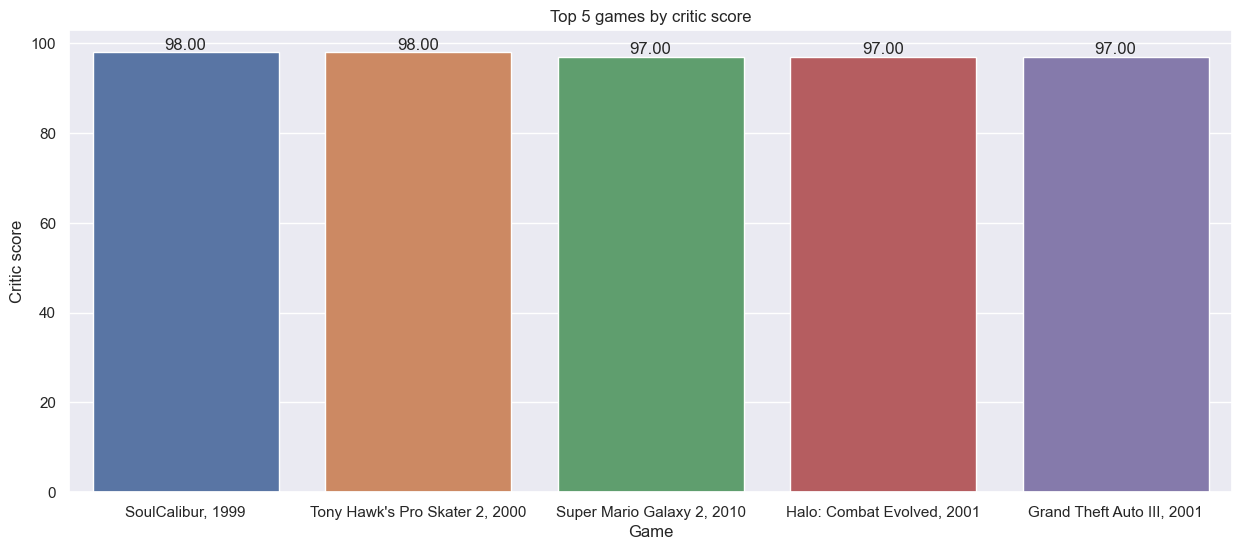

In [499]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text(
        f"""
        SELECT *
        FROM average_game_critic_score
        ORDER BY average_game_critic_score."Average_Critic_Score" DESC
        LIMIT 5
        """
    )
    result = conn.execute(query)
    rows = result.fetchall()
    
    data = pd.DataFrame(rows)
    data['Year_of_Release'] = data['Year_of_Release'].astype(str)
    data['Name_and_Year'] = data['Name'].str.cat(data['Year_of_Release'], sep=', ')

    print(data.head(5))

    sns.set(style="darkgrid")
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x=data['Name_and_Year'], y=data['Average_Critic_Score'], label='Critic score')

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')


    plt.xlabel('Game')
    plt.ylabel('Critic score')
    plt.title('Top 5 games by critic score')


    plt.show()

### Top 5 best rated games of all time by user score

Connection successful = True
                                    Name Year_of_Release  Average_User_Score  \
0                     Breath of Fire III            2005  9.7000000000000000   
1  Harvest Moon: Friends of Mineral Town            2003  9.6000000000000000   
2        Boktai: The Sun is in Your Hand            2003  9.6000000000000000   
3                      Cory in the House            2007  9.5000000000000000   
4               Golden Sun: The Lost Age            2002  9.5000000000000000   

                                 Name_and_Year  
0                     Breath of Fire III, 2005  
1  Harvest Moon: Friends of Mineral Town, 2003  
2        Boktai: The Sun is in Your Hand, 2003  
3                      Cory in the House, 2007  
4               Golden Sun: The Lost Age, 2002  


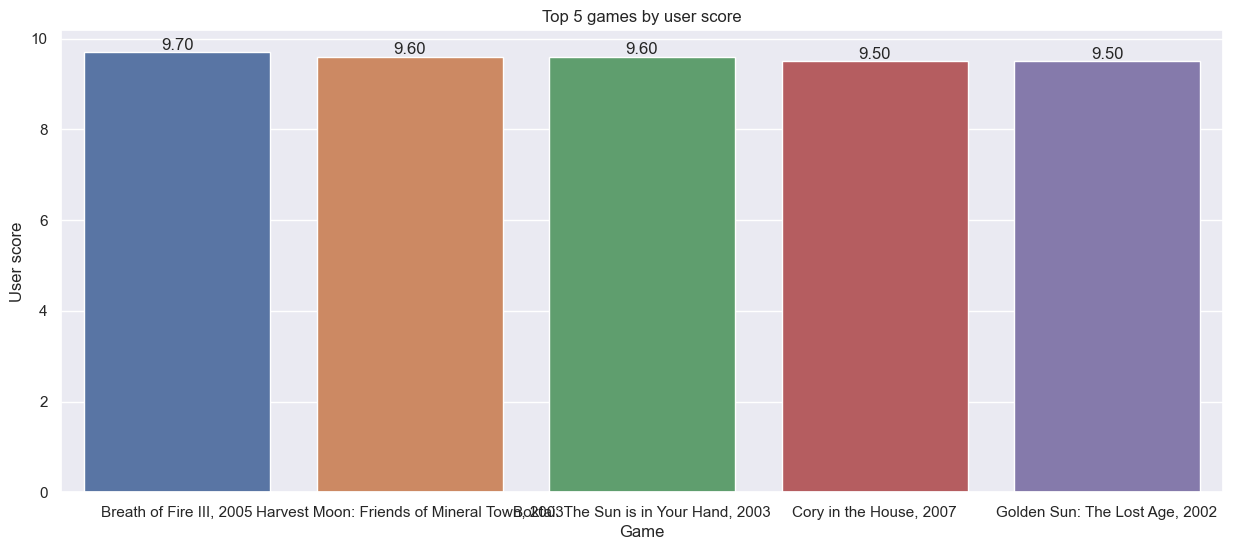

In [500]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text(
        f"""
        SELECT *
        FROM average_game_user_score
        ORDER BY average_game_user_score."Average_User_Score" DESC
        LIMIT 5
        """
    )
    result = conn.execute(query)
    rows = result.fetchall()
    
    data = pd.DataFrame(rows)
    data['Year_of_Release'] = data['Year_of_Release'].astype(str)
    data['Name_and_Year'] = data['Name'].str.cat(data['Year_of_Release'], sep=', ')

    print(data.head(5))

    sns.set(style="darkgrid")
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x=data['Name_and_Year'], y=data['Average_User_Score'], label='User score')

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')


    plt.xlabel('Game')
    plt.ylabel('User score')
    plt.title('Top 5 games by user score')


    plt.show()

### Top 5 best selling games of all time

Connection successful = True
                 Name Year_of_Release Total_Sales             Name_and_Year
0          Wii Sports            2006       82.53          Wii Sports, 2006
1   Super Mario Bros.            1985       40.24   Super Mario Bros., 1985
2  Grand Theft Auto V            2013       37.31  Grand Theft Auto V, 2013
3      Mario Kart Wii            2008       35.52      Mario Kart Wii, 2008
4   Wii Sports Resort            2009       32.77   Wii Sports Resort, 2009


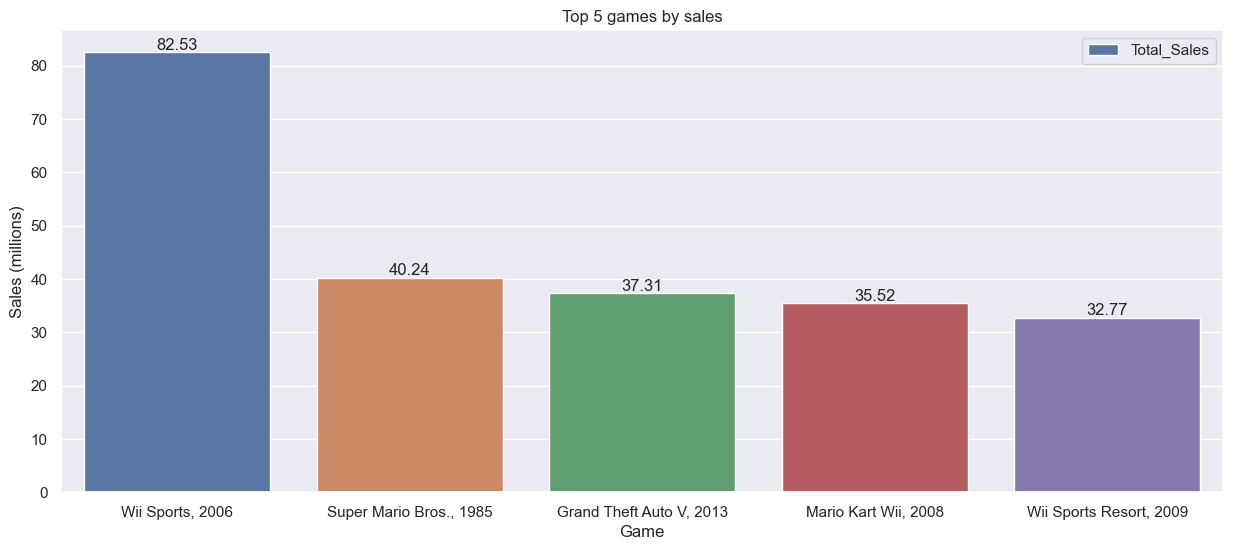

In [501]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text(
        f"""
        SELECT 
            sales."Name",
            sales."Year_of_Release",
            SUM(sales."Global_Sales") AS "Total_Sales"
        FROM sales
        GROUP BY sales."Name", sales."Year_of_Release"
        ORDER BY "Total_Sales" DESC
        LIMIT 5
        """
    )
    result = conn.execute(query)
    rows = result.fetchall()
    
    data = pd.DataFrame(rows)
    data['Year_of_Release'] = data['Year_of_Release'].astype(str)
    data['Name_and_Year'] = data['Name'].str.cat(data['Year_of_Release'], sep=', ')
    print(data.head(5))

    sns.set(style="darkgrid")
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x=data['Name_and_Year'], y=data['Total_Sales'], label='Total_Sales')

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')


    plt.xlabel('Game')
    plt.ylabel('Sales (millions)')
    plt.title('Top 5 games by sales')

    plt.legend()

    plt.show()

### Sales per year
- chart displays total sales of games up to 2016 depending on their years of release
- the rise from the start to the peak should indicate the trend of game sales
- after the peak, the years remaining until 2016 indicate on average how long does it take until next year's release outsells this year's release

Connection successful = True
   Year_of_Release Total_NA_Sales Total_EU_Sales Total_JP_Sales  \
0             1980          10.59           0.67              0   
1             1981          33.40           1.96              0   
2             1982          26.92           1.65              0   

  Total_Other_Sales Total_Global_Sales  
0              0.12              11.38  
1              0.32              35.77  
2              0.31              28.86  


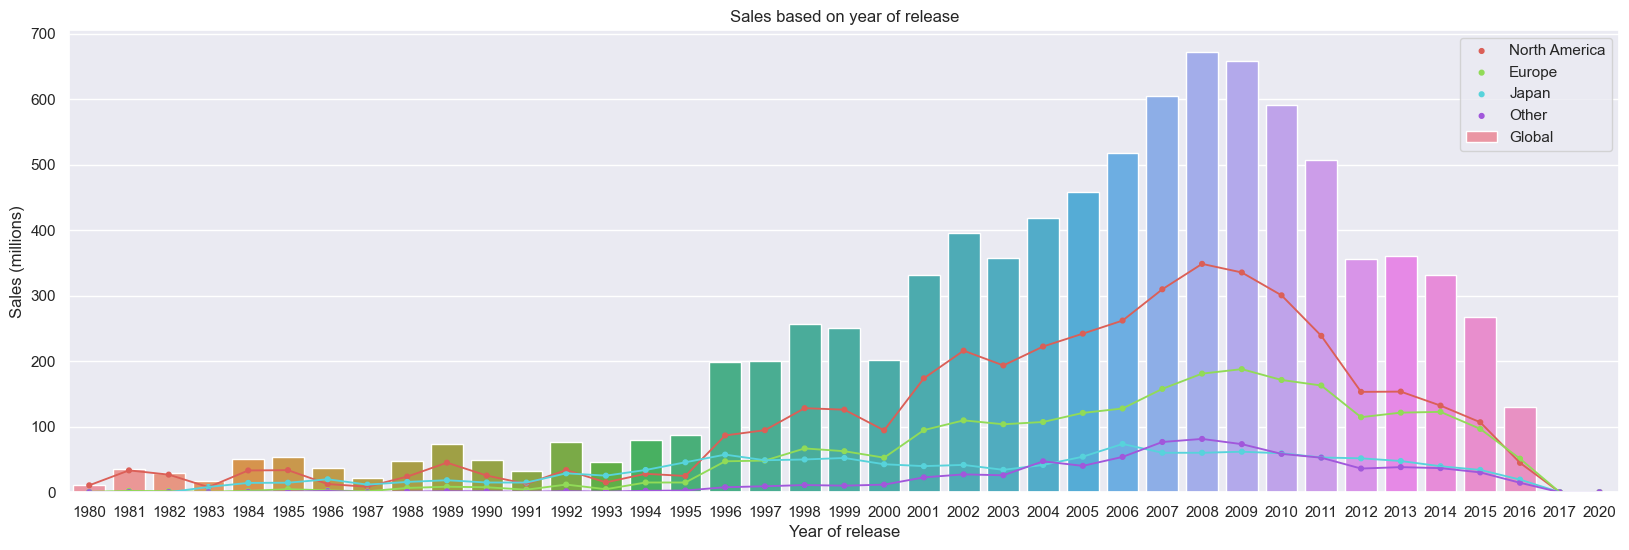

In [504]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text(
        f"""
        SELECT 
            sales."Year_of_Release",
            SUM(sales."NA_Sales") AS "Total_NA_Sales",
            SUM(sales."EU_Sales") AS "Total_EU_Sales",
            SUM(sales."JP_Sales") AS "Total_JP_Sales",
            SUM(sales."Other_Sales") AS "Total_Other_Sales",
            SUM(sales."Global_Sales") AS "Total_Global_Sales"
        FROM sales
        WHERE sales."Year_of_Release" IS NOT NULL
        GROUP BY sales."Year_of_Release"
        ORDER BY sales."Year_of_Release";
        """
    )

    result = conn.execute(query)
    rows = result.fetchall()
    
    data = pd.DataFrame(rows)
    #data['Year_of_Release'] = data['Year_of_Release'] - data['Year_of_Release'].min()
    print(data.head(3))

    sns.set(style="darkgrid")
    plt.figure(figsize=(20, 6))

    sns.barplot(data=data, x='Year_of_Release', y='Total_Global_Sales', label='Global')
    palette = sns.color_palette('hls', 4)

    sns.pointplot(data=data, x='Year_of_Release', y='Total_NA_Sales', label='North America', scale=0.5,  color=palette[0])
    sns.pointplot(data=data, x='Year_of_Release', y='Total_EU_Sales', label='Europe', scale=0.5, color=palette[1])
    sns.pointplot(data=data, x='Year_of_Release', y='Total_JP_Sales', label='Japan', scale=0.5, color=palette[2])
    sns.pointplot(data=data, x='Year_of_Release', y='Total_Other_Sales', label='Other', scale=0.5, color=palette[3])



    plt.xlabel('Year of release')
    plt.ylabel('Sales (millions)')
    plt.title('Sales based on year of release')

    plt.legend()

    plt.show()

### Game releases per platform

Connection successful = True
  Platform  Count
0     PCFX      1
1       GG      1
2     TG16      2


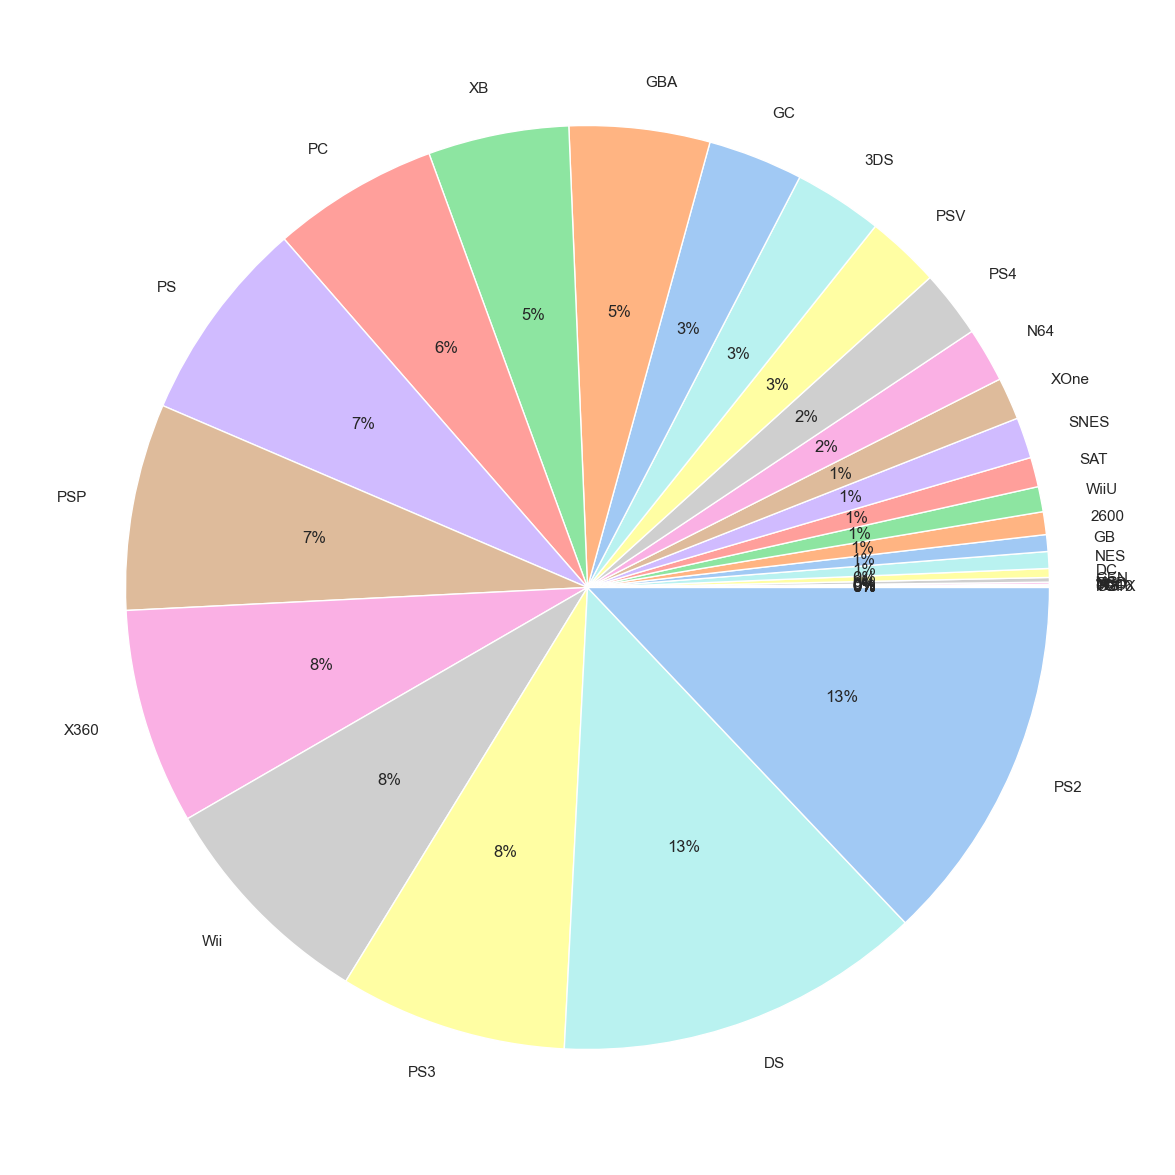

In [503]:
with engine.connect() as conn:
    print(f"Connection successful = {bool(conn)}")

    query = sqlalchemy.text(
        f"""
        SELECT 
            games_info."Platform",
            COUNT(*) as "Count"
        FROM games_info
        WHERE games_info."Platform" IS NOT NULL
        GROUP BY games_info."Platform"
        ORDER BY "Count";
        """
    )

    result = conn.execute(query)
    rows = result.fetchall()
    
    data = pd.DataFrame(rows)
    print(data.head(3))

    sns.set(style="darkgrid")
    plt.figure(figsize=(15,15))

    colors = sns.color_palette('pastel')

    labels = data['Platform']
    
    plt.pie(data['Count'], labels = labels, colors = colors, autopct='%.0f%%')
    plt.show()